In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from sklearn.base import BaseEstimator, ClassifierMixin
from torch.distributions.multivariate_normal import MultivariateNormal
from torch.distributions import Normal
import os, sys
sys.path.append(os.path.join("/home/ra43rid/torch_plnet"))
torch.set_default_device("cuda")
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


class TorchMultivariateGaussianClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, class_params=None, device="cpu"):
        """
        Initialize the classifier with class parameters.

        Parameters:
        class_params: dict
            A dictionary where keys are class labels and values are dictionaries with
            'mean' (vector), 'cov' (matrix), and 'prior' for each class.
        device: str
            The device to use for computations ('cpu' or 'cuda').
        """
        self.class_params = class_params if class_params is not None else {}
        self.device = torch.device(device)
        self.classes_ = torch.tensor(list(self.class_params.keys()), device=self.device)
        self.n_features = len(self.class_params[0]["cov"])
        self.n_classes = len(self.classes_)
    
    def fit(self, X, y=None):
        """
        Fit method for compatibility. This classifier doesn't require fitting.
        """
        self.classes_ = torch.tensor(list(self.class_params.keys()), device=self.device)
        return self
    
    def predict_proba(self, X):
        """
        Predict the probability of each class for the given input data X.

        Parameters:
        X: torch.Tensor or array-like of shape (n_samples, n_features)
            Input features.

        Returns:
        probs: torch.Tensor of shape (n_samples, n_classes)
            Predicted probabilities for each class.
        """
        if not isinstance(X, torch.Tensor):
            X = torch.tensor(X, device=self.device, dtype=torch.float32)
        
        probs = torch.zeros((X.shape[0], len(self.classes_)), device=self.device)
        for i, c in enumerate(self.classes_):
            mean = torch.tensor(self.class_params[int(c)]["mean"], device=self.device, dtype=torch.float32)
            cov = torch.tensor(self.class_params[int(c)]["cov"], device=self.device, dtype=torch.float32)
            prior = self.class_params[int(c)]["prior"]
            
            # Multivariate normal distribution
            mvn_dist = MultivariateNormal(mean, covariance_matrix=cov)
            px_given_y = torch.exp(mvn_dist.log_prob(X))
            
            # Combine with prior
            probs[:, i] = px_given_y * prior
        
        # Normalize to get P(y=c|x)
        probs /= probs.sum(dim=1, keepdim=True)
        return probs
    
    def predict(self, X):
        """
        Predict the class label for each sample in X.

        Parameters:
        X: torch.Tensor or array-like of shape (n_samples, n_features)
            Input features.

        Returns:
        predictions: torch.Tensor of shape (n_samples,)
            Predicted class labels.
        """
        probs = self.predict_proba(X)
        return self.classes_[torch.argmax(probs, dim=1)]
    
    def generate_data(self, n_samples=100, seed=42):
        """
        Generate synthetic data using the predefined class parameters.

        Parameters:
        n_samples: int
            Number of samples to generate.

        Returns:
        X: torch.Tensor of shape (n_samples, n_features)
            Generated features.
        y: torch.Tensor of shape (n_samples,)
            Generated labels.
        """
        X = []
        y = []

        torch.manual_seed(seed) 
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

        for _ in range(n_samples):
            # Sample class based on priors
            sampled_class = torch.multinomial(
                torch.tensor([self.class_params[int(c)]["prior"] for c in self.classes_], device=self.device),
                num_samples=1
            ).item()
            mean = torch.tensor(self.class_params[int(self.classes_[sampled_class])]["mean"], device=self.device, dtype=torch.float32)
            cov = torch.tensor(self.class_params[int(self.classes_[sampled_class])]["cov"], device=self.device, dtype=torch.float32)
            
            # Sample feature vector from the corresponding multivariate Gaussian
            mvn_dist = MultivariateNormal(mean, covariance_matrix=cov)
            sampled_x = mvn_dist.sample()
            X.append(sampled_x)
            y.append(self.classes_[sampled_class].item())
        
        return torch.stack(X), torch.tensor(y, device=self.device)

class TorchGaussianSyntheticClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, class_params=None, device="cpu"):
        """
        Initialize the classifier with class parameters.

        Parameters:
        class_params: dict
            A dictionary where keys are class labels and values are dictionaries with
            'mean', 'std', and 'prior' for each class.
        device: str
            The device to use for computations ('cpu' or 'cuda').
        """
        self.class_params = class_params if class_params is not None else {}
        self.device = torch.device(device)
        self.classes_ = torch.tensor(list(self.class_params.keys()), device=self.device)
        self.n_features = 1
        self.n_classes = len(self.classes_)
    
    def fit(self, X, y=None):
        """
        Fit method for compatibility. This classifier doesn't require fitting.
        """
        self.classes_ = torch.tensor(list(self.class_params.keys()), device=self.device)
        return self
    
    def predict_proba(self, X):
        """
        Predict the probability of each class for the given input data X.

        Parameters:
        X: torch.Tensor or array-like of shape (n_samples,)
            Input features.

        Returns:
        probs: torch.Tensor of shape (n_samples, n_classes)
            Predicted probabilities for each class.
        """
        if not isinstance(X, torch.Tensor):
            X = torch.tensor(X, device=self.device, dtype=torch.float32)
        
        probs = torch.zeros((len(X), len(self.classes_)), device=self.device)
        for i, c in enumerate(self.classes_):
            mean = self.class_params[int(c)]["mean"]
            std = self.class_params[int(c)]["std"]
            prior = self.class_params[int(c)]["prior"]
            
            # Calculate Gaussian PDF: P(x|y=c)
            normal_dist = Normal(loc=mean, scale=std)
            px_given_y = torch.exp(normal_dist.log_prob(X))
            
            # Combine with prior: P(x|y=c) * P(y=c)
            probs[:, i] = px_given_y * prior
        
        # Normalize to get P(y=c|x)
        probs /= probs.sum(dim=1, keepdim=True)
        return probs
    
    def predict(self, X):
        """
        Predict the class label for each sample in X.

        Parameters:
        X: torch.Tensor or array-like of shape (n_samples,)
            Input features.

        Returns:
        predictions: torch.Tensor of shape (n_samples,)
            Predicted class labels.
        """
        probs = self.predict_proba(X)
        return self.classes_[torch.argmax(probs, dim=1)]

    def generate_data(self, n_samples=100, seed=42):
        """
        Generate synthetic data using the predefined class parameters.

        Parameters:
        n_samples: int
            Number of samples to generate.

        Returns:
        X: torch.Tensor of shape (n_samples,)
            Generated features.
        y: torch.Tensor of shape (n_samples,)
            Generated labels.
        """


        torch.manual_seed(seed) 
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)


        X = []
        y = []
        for _ in range(n_samples):
            # Sample class based on priors
            sampled_class = torch.multinomial(
                torch.tensor([self.class_params[int(c)]["prior"] for c in self.classes_], device=self.device),
                num_samples=1
            ).item()
            # Sample feature value from the corresponding Gaussian
            mean = self.class_params[int(self.classes_[sampled_class])]["mean"]
            std = self.class_params[int(self.classes_[sampled_class])]["std"]
            normal_dist = Normal(loc=mean, scale=std)
            sampled_x = normal_dist.sample().item()
            X.append(sampled_x)
            y.append(self.classes_[sampled_class].item())
        
        return torch.tensor(X, device=self.device), torch.tensor(y, device=self.device)

def goodman_kruskal_gamma(x, y):
    """
    Compute Goodman and Kruskal's Gamma for two ordinal variables.
    
    Parameters:
    x, y: Lists or arrays of ordinal data (same length)
    
    Returns:
    gamma: Goodman and Kruskal's Gamma
    """
    if len(x) != len(y):
        raise ValueError("Both variables must have the same length.")
    
    concordant = 0
    discordant = 0
    
    n = len(x)
    for i in range(n - 1):
        for j in range(i + 1, n):
            # Determine concordance or discordance
            if (x[i] > x[j] and y[i] > y[j]) or (x[i] < x[j] and y[i] < y[j]):
                concordant += 1
            elif (x[i] > x[j] and y[i] < y[j]) or (x[i] < x[j] and y[i] > y[j]):
                discordant += 1
    
    # Compute Gamma
    if concordant + discordant == 0:
        return 0  # Avoid division by zero
    gamma = (concordant - discordant) / (concordant + discordant)
    return gamma

from torchcp.classification.score import APS, THR, SAPS
aps = APS(score_type="identity", randomized=False)
rand_aps = APS(score_type="identity", randomized=True)
lac = THR(score_type="identity",)
saps = SAPS(score_type="identity",randomized=False)

class_params_1f_2c = {
    0: {"mean": 1, "std": 1, "prior": 0.3},
    1: {"mean": 3, "std": 1, "prior": 0.4},
    # 2: {"mean": 4, "std": 2.2, "prior": 0.3},
}   

class_params_1f_3c = {
    0: {"mean": 1, "std": 1, "prior": 0.3},
    1: {"mean": 3, "std": 1, "prior": 0.4},
    2: {"mean": 4, "std": 2.2, "prior": 0.3},
}   

# Initialize and fit the generator
class_params_2d_3c = {
    0: {
        "mean": [2.5, 2.0],  # Mean vector for class 0
        "cov": [
            [1.0, 0.5],
            [0.5, 1.2],
            # [0.3, 0.4, 0.8]
        ],  # Covariance matrix for class 0
        "prior": 0.3  # Prior probability for class 0
    },
    1: {
        "mean": [3.5, 4.0],  # Mean vector for class 1
        "cov": [
            [1.5, 0.3],
            [0.3, 1.1],
            # [0.2, 0.1, 0.9]
        ],  # Covariance matrix for class 1
        "prior": 0.4  # Prior probability for class 1
    },
    2: {
        "mean": [2.0, 1.0],  # Mean vector for class 2
        "cov": [
            [1.2, 0.4],
            [0.4, 1.3],
            # [0.3, 0.5, 1.4]
        ],  # Covariance matrix for class 2
        "prior": 0.3  # Prior probability for class 2
    },
}

# Initialize and fit the generator
class_params_3d_3c = {
    0: {
        "mean": [3.0, 2.0, 4.0],  # Mean vector for class 0
        "cov": [
            [1.0, 0.5, 0.3],
            [0.5, 1.2, 0.4],
            [0.3, 0.4, 0.8]
        ],  # Covariance matrix for class 0
        "prior": 1/3  # Prior probability for class 0
    },
    1: {
        "mean": [3.0, 4.0, 3.0],  # Mean vector for class 1
        "cov": [
            [1.5, 0.3, 0.2],
            [0.3, 1.1, 0.1],
            [0.2, 0.1, 0.9]
        ],  # Covariance matrix for class 1
        "prior": 1/3  # Prior probability for class 1
    },
    2: {
        "mean": [1.0, 2.0, 4.0],  # Mean vector for class 2
        "cov": [
            [1.2, 0.4, 0.3],
            [0.4, 1.3, 0.5],
            [0.3, 0.5, 1.4]
        ],  # Covariance matrix for class 2
        "prior": 1/3  # Prior probability for class 2
    },
}


# Initialize and fit the generator
class_params_2d_2c = {
    0: {
        "mean": [3.0, 2.0],  # Mean vector for class 0
        "cov": [
            [1.0, 0.5],
            [0.5, 1.2],
        ],  # Covariance matrix for class 0
        "prior": 0.3  # Prior probability for class 0
    },
    1: {
        "mean": [2.0, 3.0],  # Mean vector for class 1
        "cov": [
            [1.5, 0.3],
            [0.3, 1.1],
        ],  # Covariance matrix for class 1
        "prior": 0.4  # Prior probability for class 1
    },
    # 2: {
    #     "mean": [1.0, 2.0, 2.0],  # Mean vector for class 2
    #     "cov": [
    #         [1.2, 0.4],
    #         [0.4, 1.3],
    #         # [0.3, 0.5, 1.4]
    #     ],  # Covariance matrix for class 2
    #     "prior": 0.3  # Prior probability for class 2
    # },
}

gen_1d_2c = TorchGaussianSyntheticClassifier(class_params=class_params_1f_2c, device="cuda")
gen_1d_3c = TorchGaussianSyntheticClassifier(class_params=class_params_1f_3c, device="cuda")
gen_3d_3c = TorchMultivariateGaussianClassifier(class_params=class_params_3d_3c, device="cuda")
gen_2d_2c = TorchMultivariateGaussianClassifier(class_params=class_params_2d_2c, device="cuda")
gen_2d_3c = TorchMultivariateGaussianClassifier(class_params=class_params_2d_3c, device="cuda")

c:\Users\jonas\anaconda3\envs\cp_rank\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class OracleAnnotator:
    def __init__(self,score, generator):
        self.score = score
        self.classes_ = generator.classes_
        self.generator = generator

    # we assume y is already label encoded
    def get_conformity(self, X, y):
        y_pred_proba = self.generator.predict_proba(X)
        scores = self.score(y_pred_proba, y)
        return scores

In [3]:
from zmq import device
from util.ranking_datasets import LabelPairDataset
from models.ranking_models import LabelRankingModel
from torch.utils.data.dataloader import DataLoader
from scipy.stats import kendalltau
import matplotlib.pyplot as plt
import torch
from scipy.stats import kendalltau
from joblib import Parallel, delayed
torch.set_default_device("cuda")
import hashlib

def derive_seed(seed, index):
    combined = f"{seed}-{index}".encode()
    return int(hashlib.sha256(combined).hexdigest(), 16) % (2**32)



In [4]:
gen = gen_2d_3c
seeds = list(range(0,5))


In [5]:
def create_from_classification_data(X, y, num_classes):
    X_pairs = []
    y_pairs = []

    for X_vec, label in zip(X, y):
        for k in range(0, num_classes):
            if k == label:
                continue
            X_pairs.append(
                torch.vstack(
                    [
                        torch.tensor(X_vec, dtype=torch.float32),
                        torch.tensor(X_vec, dtype=torch.float32),
                    ]
                )
            )
            y_pairs.append(
                torch.vstack(
                    [
                        torch.tensor(label, dtype=torch.long),
                        torch.tensor(k, dtype=torch.long),
                    ]
                )
            )

    X_pairs = torch.stack(X_pairs)
    y_pairs = torch.stack(y_pairs)
    return X_pairs, y_pairs


def generate_bt_preferences_batch(gen, X,y, use_bt = True):

    probs = gen.predict_proba(X)
    prob_tensor = torch.take_along_dim(probs, y.unsqueeze(-1), dim=1).squeeze()
    assert prob_tensor.dim() == 1 and prob_tensor.size(0) % 2 == 0, "Input must be 1D tensor of even length"



    pairs = prob_tensor.view(-1, 2)
    s1 = pairs[:, 0]
    s2 = pairs[:, 1]

    if use_bt:
        prob_1_pref = torch.sigmoid(s1 - s2)
        preferences = torch.bernoulli(prob_1_pref)
    else:
        preferences = s1 > s2
    
    X_pairs = X.view(-1, 2, X.size(1))      # (N/2, 2, D)
    y_pairs = y.view(-1, 2)                 # (N/2, 2)
    prob_pairs = probs.view(-1, 2)          # (N/2, 2)

    # Bradley-Terry preference: probability first is preferred
    prob_1_pref = torch.sigmoid(prob_pairs[:, 0] - prob_pairs[:, 1])
    # Reorder both features and labels

    preferred_X = torch.where(preferences.unsqueeze(-1), X_pairs[:, 0], X_pairs[:, 1])
    nonpreferred_X = torch.where(preferences.unsqueeze(-1), X_pairs[:, 1], X_pairs[:, 0])
    paired_X = torch.stack([preferred_X, nonpreferred_X], dim=1)  # (N/2, 2, D)

    preferred_y = torch.where(preferences, y_pairs[:, 0], y_pairs[:, 1])
    nonpreferred_y = torch.where(preferences, y_pairs[:, 1], y_pairs[:, 0])
    paired_y = torch.stack([preferred_y, nonpreferred_y], dim=1)  # (N/2, 2)
    return paired_X, paired_y.unsqueeze(-1)

In [6]:
from models.classifier_model import ClassifierModel
def fit_classifier(X_train, y_train):

    model = ClassifierModel(
        input_dim=X_train.shape[1], hidden_dims=[5], output_dim=3
    )
    # model.cuda()
    model.fit(
        X_train.cpu().detach().numpy(),
        y_train.cpu().detach().numpy(),
        num_epochs=5000,
        patience=50,
        batch_size=32,
        val_frac=0.0,
        learning_rate=0.01,
    )

    return model

In [ ]:
from models.ranking_models import LabelRankingModel
def fit_ranker(X_train, y_train, X_pairs=None, y_pairs=None):

    model = LabelRankingModel(
        input_dim=X_train.shape[1], hidden_dims=[5], output_dim=3
    )
    model.cuda()

    X_train_prf, y_train_prf = create_from_classification_data(X_train, y_train, 3)

    X_train_overall = torch.concat([X_train_prf, X_pairs])
    y_train_overall = torch.concat([y_train_prf, y_pairs])


    print(len(y_train_prf),len(y_train), len(y_train_overall))
    ds = LabelPairDataset()
    ds.create_from_numpy_pairs(X_train_overall, y_train_overall)
    pair_loader = DataLoader(ds, batch_size=32)

    model._fit(
        train_loader=pair_loader,
        val_loader=None,
        num_epochs=5000,
        patience=50,
        learning_rate=0.01,
        verbose=True
    )

    return model

In [ ]:
from itertools import product

from torchcp.classification.score import APS, THR, TOPK, RAPS, SAPS, Margin, KNN
from conformal.conformal import IDENTITY, OWN_APS
from torchcp.classification.predictor import SplitPredictor
from torchcp.classification import Metrics
from itertools import product
from util.ranking_datasets import TabularDataset, LabelPairDataset


nums_clf_data = [10,20,30,40,50,100]
nums_clf_data = [5,10,20,30,50,70,100]
seeds = [1]
num_prf_data = 250
num_calib_data = 100

results = []

for seed, num_clf_data in product(seeds, nums_clf_data):

    X_calib, y_calib = gen.generate_data(num_calib_data)
    # two times the number because we want num_prf_data preferences
    X_prf, y_prf = gen.generate_data(2*num_calib_data)
    X_pairs, y_pairs = generate_bt_preferences_batch(gen, X_prf, y_prf, False)

    X_clf, y_clf = gen.generate_data(num_clf_data)

    X_test, y_test = gen.generate_data(250)

    ranker = fit_ranker(X_clf, y_clf, X_pairs, y_pairs)
    classifier = fit_classifier(X_clf, y_clf)



    ranker.num_classes = 3


    test_dataset = TabularDataset(X_test, y_test)
    test_loader = DataLoader(test_dataset, batch_size=32)

    # Classifier

    names = ["rand_aps", "aps", "thr"]
    alphas = [0.02,0.05,0.1,0.2]

    conformity_scores = [
        APS(randomized=True),
        APS(randomized=False),
        THR()
    ]
    for (name, conformity_score), alpha in product(
        zip(names, conformity_scores), alphas
    ):
        predictor = SplitPredictor(conformity_score, classifier)

        gradient_updates = predictor._model.gradient_updates

        cal_dataset = TabularDataset(X_calib, y_calib)

        cal_loader = DataLoader(cal_dataset,batch_size=32)

        predictor.calibrate(cal_loader, alpha)

        predictions_sets_list = []
        predictions_list = []
        labels_list = []
        logits_list = []
        feature_list = []

        # Evaluate in inference mode
        predictor._model.eval()
        with torch.no_grad():
            for batch in test_loader:
                # Move batch to device and get predictions
                inputs = batch[0]
                labels = batch[1]

                batch_predictions = predictor.predict(inputs)

                logits = classifier(inputs)

                predicted_label = logits.argmax(axis=1)
                # Accumulate predictions and labels
                predictions_sets_list.append(batch_predictions)
                predictions_list.append(predicted_label)
                labels_list.append(labels)
                logits_list.append(logits)
                feature_list.append(inputs)

            # Concatenate all batches
            val_prediction_sets = torch.cat(predictions_sets_list, dim=0)  # (N_val x C)
            val_predictions = torch.cat(predictions_list, dim=0)
            val_labels = torch.cat(labels_list, dim=0)  # (N_val,)
            val_logits = torch.cat(logits_list, dim=0)
            val_features = torch.cat(feature_list, dim=0)

            y_pred = val_predictions.detach().cpu().numpy()
            y_true = val_labels.detach().cpu().numpy()
            # Compute evaluation metrics
            metric = Metrics()
            avg_size = metric("average_size")(
                    prediction_sets=val_prediction_sets, labels=val_labels
                )
            coverage = metric("coverage_rate")(
                    prediction_sets=val_prediction_sets, labels=val_labels
                )
            
            results.append([seed, num_clf_data, alpha, name, avg_size, coverage])

    # Ranker
    test_dataset = TabularDataset(X_test, y_test)
    test_loader = DataLoader(test_dataset, batch_size=32)

    alphas = [0.02,0.05,0.1,0.2]

    for alpha in alphas:
        predictor = SplitPredictor(IDENTITY(), ranker)

        gradient_updates = predictor._model.gradient_updates

        cal_dataset = TabularDataset(X_calib, y_calib)

        cal_loader = DataLoader(cal_dataset,batch_size=32)

        predictor.calibrate(cal_loader, alpha)

        predictions_sets_list = []
        predictions_list = []
        labels_list = []
        logits_list = []
        feature_list = []

        # Evaluate in inference mode
        predictor._model.eval()
        with torch.no_grad():
            for batch in test_loader:
                # Move batch to device and get predictions
                inputs = batch[0]
                labels = batch[1]

                batch_predictions = predictor.predict(inputs)

                logits = classifier(inputs)

                predicted_label = logits.argmax(axis=1)
                # Accumulate predictions and labels
                predictions_sets_list.append(batch_predictions)
                predictions_list.append(predicted_label)
                labels_list.append(labels)
                logits_list.append(logits)
                feature_list.append(inputs)

            # Concatenate all batches
            val_prediction_sets = torch.cat(predictions_sets_list, dim=0)  # (N_val x C)
            val_predictions = torch.cat(predictions_list, dim=0)
            val_labels = torch.cat(labels_list, dim=0)  # (N_val,)
            val_logits = torch.cat(logits_list, dim=0)
            val_features = torch.cat(feature_list, dim=0)

            y_pred = val_predictions.detach().cpu().numpy()
            y_true = val_labels.detach().cpu().numpy()
            # Compute evaluation metrics
            metric = Metrics()

            avg_size = metric("average_size")(
                    prediction_sets=val_prediction_sets, labels=val_labels
                )
            coverage = metric("coverage_rate")(
                    prediction_sets=val_prediction_sets, labels=val_labels
                )
            
            results.append([seed, num_clf_data, alpha, "ranker", avg_size, coverage])


c:\Users\jonas\anaconda3\envs\cp_rank\Lib\site-packages\torch\utils\_device.py:106: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)


10 5 110
Epoch 1/5000
  Train Loss: 0.2079
Epoch 2/5000
  Train Loss: 0.1879
Epoch 3/5000
  Train Loss: 0.1714
Epoch 4/5000
  Train Loss: 0.1584
Epoch 5/5000
  Train Loss: 0.1490
Epoch 6/5000
  Train Loss: 0.1426
Epoch 7/5000
  Train Loss: 0.1387
Epoch 8/5000
  Train Loss: 0.1365
Epoch 9/5000
  Train Loss: 0.1353
Epoch 10/5000
  Train Loss: 0.1347
Epoch 11/5000
  Train Loss: 0.1344
Epoch 12/5000
  Train Loss: 0.1340
Epoch 13/5000
  Train Loss: 0.1337
Epoch 14/5000
  Train Loss: 0.1333
Epoch 15/5000
  Train Loss: 0.1328
Epoch 16/5000
  Train Loss: 0.1322
Epoch 17/5000
  Train Loss: 0.1317
Epoch 18/5000
  Train Loss: 0.1311
Epoch 19/5000
  Train Loss: 0.1306
Epoch 20/5000
  Train Loss: 0.1300
Epoch 21/5000
  Train Loss: 0.1294
Epoch 22/5000
  Train Loss: 0.1289
Epoch 23/5000
  Train Loss: 0.1283
Epoch 24/5000
  Train Loss: 0.1277
Epoch 25/5000
  Train Loss: 0.1271
Epoch 26/5000
  Train Loss: 0.1265
Epoch 27/5000
  Train Loss: 0.1259
Epoch 28/5000
  Train Loss: 0.1253
Epoch 29/5000
  Trai

In [9]:
results

[[1, 5, 0.02, 'rand_aps', 2.8520002365112305, 0.9639999866485596],
 [1, 5, 0.05, 'rand_aps', 2.9280002117156982, 0.9800000190734863],
 [1, 5, 0.1, 'rand_aps', 2.744000196456909, 0.9160000085830688],
 [1, 5, 0.2, 'rand_aps', 2.5880000591278076, 0.8479999899864197],
 [1, 5, 0.02, 'aps', 3.000000238418579, 1.0],
 [1, 5, 0.05, 'aps', 2.9160001277923584, 0.984000027179718],
 [1, 5, 0.1, 'aps', 2.9160001277923584, 0.984000027179718],
 [1, 5, 0.2, 'aps', 1.9760000705718994, 0.828000009059906],
 [1, 5, 0.02, 'thr', 2.9200000762939453, 0.9919999837875366],
 [1, 5, 0.05, 'thr', 2.9200000762939453, 0.9919999837875366],
 [1, 5, 0.1, 'thr', 2.7760000228881836, 0.9200000166893005],
 [1, 5, 0.2, 'thr', 2.572000026702881, 0.8399999737739563],
 [1, 5, 0.02, 'ranker', 2.4760000705718994, 0.9760000109672546],
 [1, 5, 0.05, 'ranker', 1.940000057220459, 0.9319999814033508],
 [1, 5, 0.1, 'ranker', 1.4920001029968262, 0.8799999952316284],
 [1, 5, 0.2, 'ranker', 1.2280000448226929, 0.800000011920929],
 [1, 10

In [ ]:
import pandas as pd
result_df = pd.DataFrame(data=results, columns=["seed","num_clf_data","alpha","method","avg_set_size","coverage_rate"])
result_df.to_csv("results_synthetic.csv")
result_df = result_df[result_df.alpha==0.1]
result_df = result_df[result_df.method!="aps"]

In [11]:
result_df

,seed,num_clf_data,alpha,method,avg_set_size,coverage_rate
2,1,5,0.1,rand_aps,2.744,0.916
10,1,5,0.1,thr,2.776,0.920
14,1,5,0.1,ranker,1.492,0.880
18,1,10,0.1,rand_aps,2.728,0.968
26,1,10,0.1,thr,2.640,0.952
30,1,10,0.1,ranker,1.608,0.892
34,1,15,0.1,rand_aps,2.120,0.880
42,1,15,0.1,thr,2.024,0.880
46,1,15,0.1,ranker,1.424,0.872
50,1,20,0.1,rand_aps,1.872,0.844


In [12]:
result_df.groupby(["num_clf_data", "alpha", "method"]).aggregate("mean").reset_index()

,num_clf_data,alpha,method,seed,avg_set_size,coverage_rate
0,5,0.1,rand_aps,1.0,2.744,0.916
1,5,0.1,ranker,1.0,1.492,0.880
2,5,0.1,thr,1.0,2.776,0.920
3,10,0.1,rand_aps,1.0,2.728,0.968
4,10,0.1,ranker,1.0,1.608,0.892
5,10,0.1,thr,1.0,2.640,0.952
6,15,0.1,rand_aps,1.0,2.120,0.880
7,15,0.1,ranker,1.0,1.424,0.872
8,15,0.1,thr,1.0,2.024,0.880
9,20,0.1,rand_aps,1.0,1.872,0.844


<Axes: xlabel='num_clf_data', ylabel='avg_set_size'>

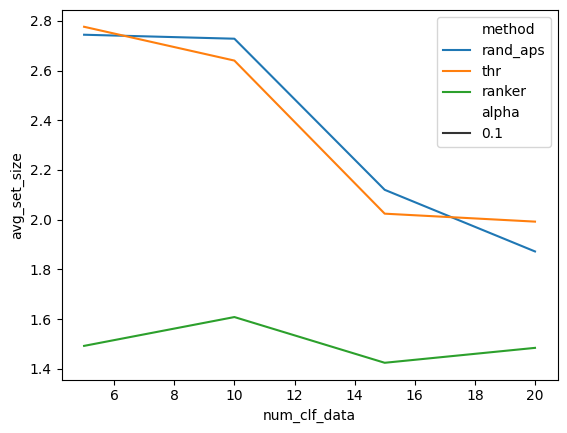

In [13]:
import seaborn as sns
sns.lineplot(data=result_df, hue="method" ,style="alpha", x="num_clf_data", y="avg_set_size")